📂 Please upload apps.csv


Saving apps.csv to apps.csv
📂 Please upload user_reviews.csv


Saving user_reviews.csv to user_reviews.csv

📊 Top Categories:
Category
FAMILY             1832
GAME                959
TOOLS               827
BUSINESS            420
MEDICAL             395
PERSONALIZATION     376
PRODUCTIVITY        374
LIFESTYLE           369
FINANCE             345
SPORTS              325
Name: count, dtype: int64


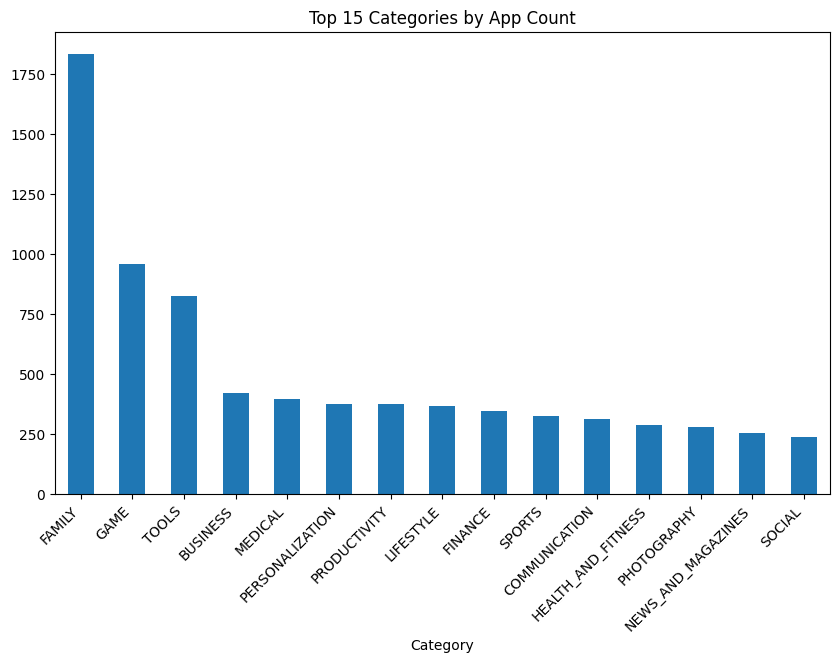

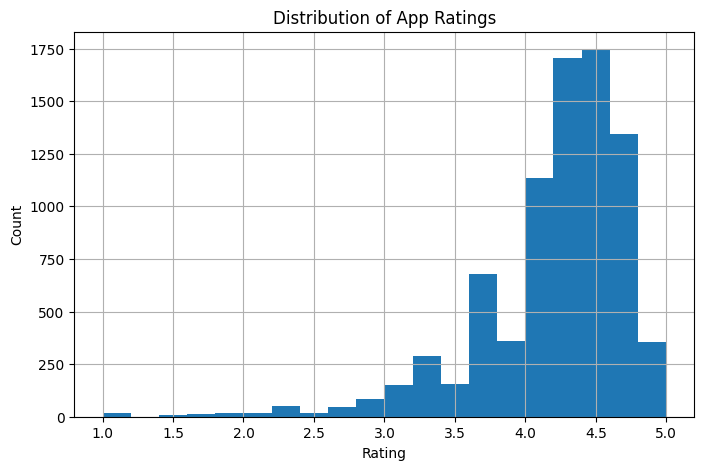

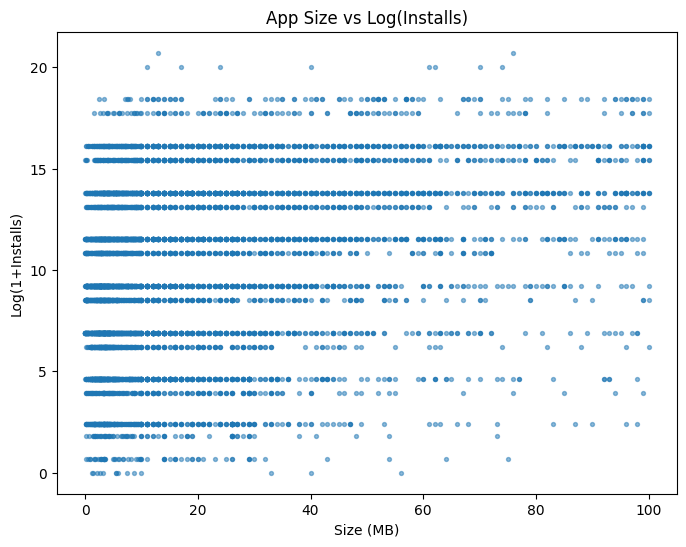

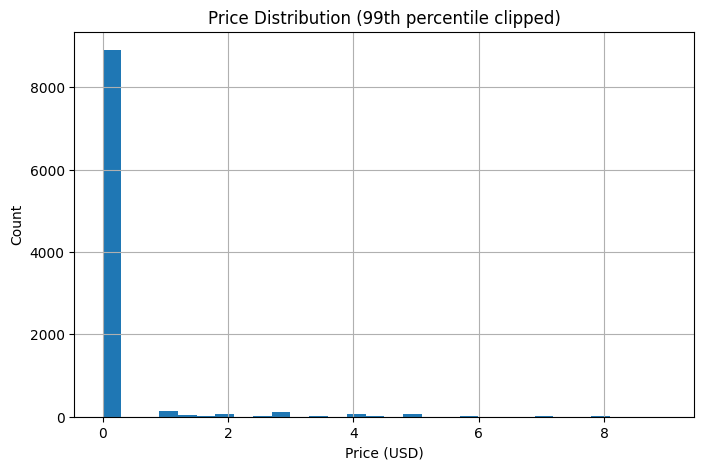

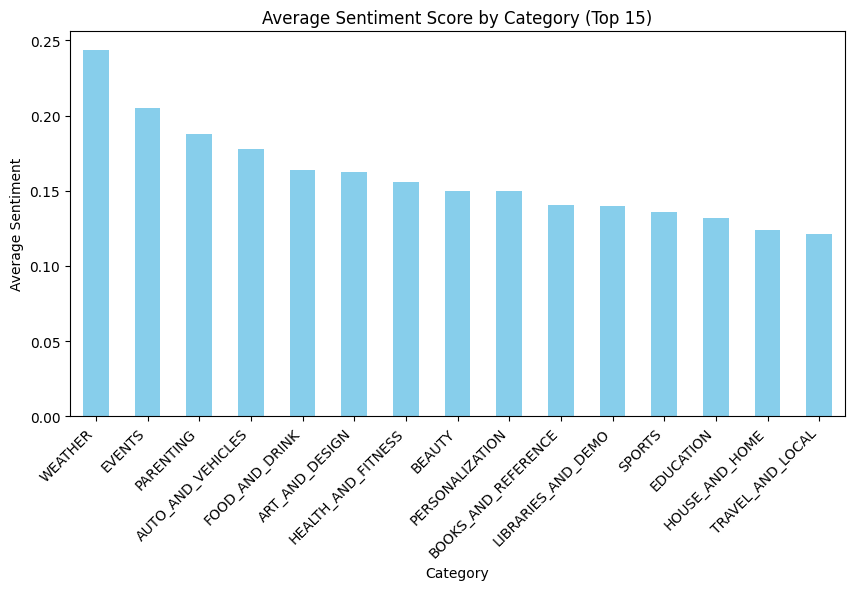

✅ Analysis complete. Cleaned files saved in Colab working directory.


In [ ]:
!pip install matplotlib pandas numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from google.colab import files
print("📂 Please upload apps.csv")
apps_file = files.upload()

print("📂 Please upload user_reviews.csv")
reviews_file = files.upload()

apps = pd.read_csv(list(apps_file.keys())[0])
reviews = pd.read_csv(list(reviews_file.keys())[0])


def clean_installs(x):
    if pd.isna(x): return np.nan
    x = str(x).replace("+","").replace(",","").replace("Free","").strip()
    return int(re.sub(r'[^\d]', '', x)) if re.search(r'\d', x) else np.nan

def clean_price(x):
    if pd.isna(x): return 0.0
    s = str(x).replace("$","").replace("USD","").replace(",","").strip()
    return float(re.sub(r'[^\d\.]', '', s)) if s else 0.0

def clean_size(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s in ['Varies with device','-']: return np.nan
    m = re.match(r'([\d\.]+)\s*([kKmM]?)', s)
    if m:
        val, unit = float(m.group(1)), m.group(2).lower()
        if unit == 'k': return val / 1024  # KB → MB
        return val
    return np.nan

def clean_rating(x):
    try: return float(x)
    except: return np.nan


apps['Installs'] = apps['Installs'].apply(clean_installs)
apps['Price'] = apps['Price'].apply(clean_price)
apps['Size_MB'] = apps['Size'].apply(clean_size)
apps['Rating'] = apps['Rating'].apply(clean_rating)
apps['Is_Free'] = apps['Price'] == 0.0
apps['Log_Installs'] = apps['Installs'].apply(lambda x: np.log1p(x) if pd.notna(x) else np.nan)


cat_counts = apps['Category'].value_counts()
print("\n📊 Top Categories:")
print(cat_counts.head(10))

plt.figure(figsize=(10,6))
cat_counts.head(15).plot(kind='bar')
plt.title('Top 15 Categories by App Count')
plt.xticks(rotation=45, ha='right')
plt.show()


plt.figure(figsize=(8,5))
apps['Rating'].dropna().hist(bins=20)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,6))
mask = apps['Size_MB'].notna() & apps['Log_Installs'].notna()
plt.scatter(apps.loc[mask, 'Size_MB'], apps.loc[mask, 'Log_Installs'], alpha=0.5, s=8)
plt.xlabel('Size (MB)')
plt.ylabel('Log(1+Installs)')
plt.title('App Size vs Log(Installs)')
plt.show()

plt.figure(figsize=(8,5))
apps['Price'][apps['Price'] <= apps['Price'].quantile(0.99)].hist(bins=30)
plt.title('Price Distribution (99th percentile clipped)')
plt.xlabel('Price (USD)')
plt.ylabel('Count')
plt.show()


positive_words = set("""good great excellent amazing love loved best useful helpful nice perfect superb happy like
awesome fantastic brilliant reliable fast smooth recommend""".split())
negative_words = set("""bad terrible awful hate hated worst slow crash crashes buggy problem problems poor unstable
annoying disappointed expensive lag""".split())

def simple_sentiment(text):
    if pd.isna(text): return 0.0
    words = re.findall(r"[a-zA-Z']+", str(text).lower())
    pos = sum(1 for w in words if w in positive_words)
    neg = sum(1 for w in words if w in negative_words)
    return (pos - neg) / np.sqrt(len(words)) if words else 0

reviews['sentiment_score'] = reviews['Translated_Review'].apply(simple_sentiment)


sentiment_summary = reviews.groupby('App')['sentiment_score'].mean().reset_index()
apps = apps.merge(sentiment_summary, on='App', how='left')

cat_sent = apps.groupby('Category')['sentiment_score'].mean().sort_values(ascending=False)
cat_sent.head(15).plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title('Average Sentiment Score by Category (Top 15)')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45, ha='right')
plt.show()


apps.to_csv('apps_cleaned_with_sentiment.csv', index=False)
reviews.to_csv('reviews_with_sentiment.csv', index=False)

print("✅ Analysis complete. Cleaned files saved in Colab working directory.")
